## Assignment 2: Linear Regression with Feature Subset Selection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

## Data preprocessing

In [ ]:
data = pd.read_csv("/content/FoDS-Assignment-2.csv")
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0


In [ ]:
# Random shuffling of data
data=data.sample(frac=1)

In [ ]:
data.shape

(1188, 14)

In [ ]:
# Missing Values
data.isna().sum()

bedrooms          0
bathrooms         0
sqft_living      14
sqft_lot          0
floors           13
waterfront        0
view              0
condition         0
grade             0
sqft_above       14
sqft_basement     0
sqft_living15     0
sqft_lot15        0
price             0
dtype: int64

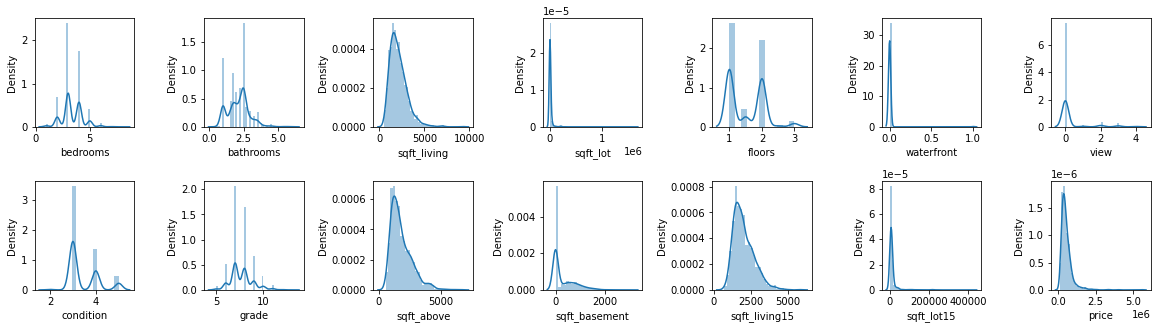

In [ ]:
# Detect Outliers
# Distribution plots for features
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20,5))
cou=1;
for i in data.columns:
  plt.subplot(2,7,cou)
  sns.distplot(data[i])
  cou+=1

plt.subplots_adjust(wspace=0.7,hspace=0.5)

plt.show()

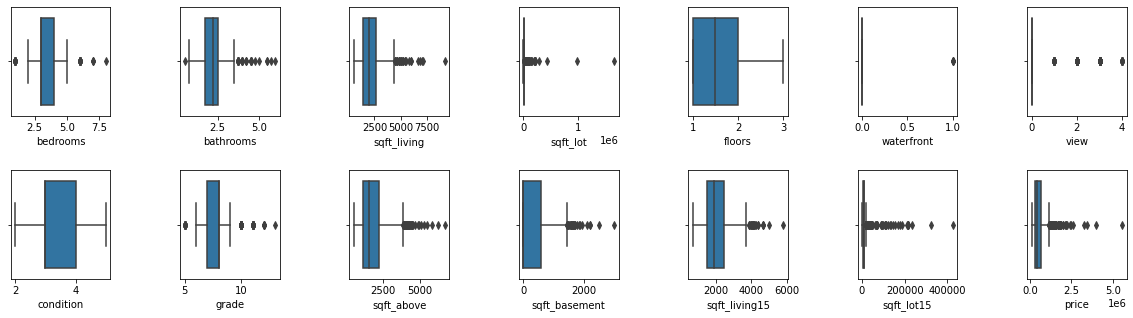

In [ ]:
# Feature box plots
plt.figure(figsize=(20,5))
cou=1;
for i in data.columns:
  plt.subplot(2,7,cou)
  sns.boxplot(data[i])
  cou+=1

plt.subplots_adjust(wspace=0.7,hspace=0.5)

plt.show()

In [ ]:
def preprocess(data,standardize=1,miss=0):
   #if 'view' in data.columns:
   #  view_dummies = pd.get_dummies(data.view,prefix='view')
   #  data = pd.concat([data,view_dummies],axis=1)
   #  data=data.drop(['view'],axis=1)
   #if 'condition' in data.columns:
   #  cond_dummies = pd.get_dummies(data.condition,prefix='condition')
   #  data = pd.concat([data,cond_dummies],axis=1)
   #  data=data.drop(['condition'],axis=1)
   #if 'grade' in data.columns:
    # grade_dummies= pd.get_dummies(data.grade,prefix='grade')
    # data = pd.concat([data,grade_dummies],axis=1)
    # data=data.drop(['grade'],axis=1)
   if(miss==0):
    data = data.dropna(axis=0)
    X_train = data.drop('price',axis=1)[:ceil(0.7*data.shape[0])]
    X_test= data.drop('price',axis=1)[ceil(0.7*data.shape[0]):]
    y_train = data['price'][:ceil(0.7*data.shape[0])]
    y_test = data['price'][ceil(0.7*data.shape[0]):]
   else:
    X_train = data.drop('price',axis=1)[:831]
    X_test= data.drop('price',axis=1)[831:]
    y_train = data['price'][:831]
    y_test = data['price'][831:]
    if 'sqft_living' in X_train.columns:
      x1_mean = X_train['sqft_living'].median()
      X_train['sqft_living']=X_train['sqft_living'].fillna(x1_mean)
      X_test['sqft_living']=X_test['sqft_living'].fillna(x1_mean)
    if 'floors' in X_train.columns:
      x2_mode = X_train['floors'].mode()[0]
      X_train['floors']=X_train['floors'].fillna(x2_mode)
      X_test['floors']=X_test['floors'].fillna(x2_mode)
    if 'sqft_above' in X_train.columns:
         x3_mean = X_train['sqft_above'].median()
         X_train['sqft_above']=X_train['sqft_above'].fillna(x3_mean)
         X_test['sqft_above']=X_test['sqft_above'].fillna(x3_mean)

   if(standardize==1):
      mn = X_train.mean()
      std = X_train.std()
      X_train = (X_train - mn)/std
      X_test = (X_test - mn)/std
      ymn=y_train.mean()
      ystd=y_train.std()
      y_train = (y_train - ymn)/ystd
      y_test = (y_test - ymn)/ystd
      
   elif(standardize==0):
      mini = X_train.min()
      maxi = X_train.max()
      X_train = (X_train - mini)/(maxi-mini)
      X_test = (X_test - mini)/(maxi-mini)
      ymini=y_train.min()
      ymaxi=y_train.max()
      y_train = (y_train - ymini)/(ymaxi-ymini)
      y_test = (y_test - ymini)/(ymaxi-ymini)
      

   return X_train,y_train,X_test,y_test

In [ ]:
X_train,y_train,X_test,y_test = preprocess(data,1,1)

In [ ]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
860,2.788170,1.378180,2.781367,0.050555,-0.957543,-0.060157,3.488751,0.858181,1.046399,1.015619,4.064776,2.380987,0.069045
303,0.658603,0.115133,0.314496,-0.079258,-0.957543,-0.060157,-0.327597,0.858181,0.222954,0.708554,-0.651948,-0.573948,-0.099926
1110,0.658603,0.115133,0.866032,-0.066026,-0.957543,-0.060157,-0.327597,0.858181,1.046399,1.334057,-0.651948,0.639431,-0.102507
945,0.658603,0.746657,0.535110,-0.117479,-0.957543,-0.060157,4.760867,0.858181,1.046399,-0.405980,1.932558,1.296083,-0.155306
439,-0.406181,-0.516390,-0.437599,-0.133879,-0.957543,-0.060157,-0.327597,-0.655934,-0.600490,-0.144406,-0.651948,0.325380,-0.148622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,-1.470965,-0.516390,-0.317264,-0.135547,-0.957543,-0.060157,2.216635,0.858181,-0.600490,-0.872264,0.984906,-0.659598,-0.249022
1014,0.658603,0.115133,-0.313253,-0.131934,0.919151,-0.060157,-0.327597,-0.655934,0.222954,-0.003383,-0.651948,-0.075749,-0.142646
173,1.723386,4.851559,4.987513,0.331529,0.919151,-0.060157,4.760867,-0.655934,3.516732,-0.258134,2.880211,2.009835,0.842286
436,-0.406181,-1.463675,-0.618102,0.028554,-0.957543,-0.060157,-0.327597,0.858181,0.222954,-0.622063,-0.135046,0.082704,0.280099


## Linear Regression Model

In [ ]:
def grad_desc(x,y,xt,yt,w,lr=0.1,epochs=500):
  x = np.array(x)
  y = np.array(y)
  xt = np.array(xt)
  yt = np.array(yt)
  print(x.shape)
  m = len(x)
  mt = len(xt)
  costs=[]
  for i in range(epochs):
    d= ((x@w)-y)
    dt = ((xt@w)-yt)
    e =  (0.5)*(d.T@d)
    et = (0.5)*(dt.T@dt)
    grad = (x.T@d)

    
    w -= (lr*grad)
    #if(i%100==0):
      #print("Epoch = ",i,"|| train_error = ",e/m,"|| test_error = ",et/mt)
    costs.append(e/m)
    
  return w,costs

In [ ]:
def linear_reg_model(X_train,X_test,y_train,y_test,lr,epochs):
  y_train = np.reshape(np.array(y_train), (X_train.shape[0],1))
  y_test = np.reshape(np.array(y_test), (X_test.shape[0],1))
  X_train = np.hstack((np.ones((X_train.shape[0],1)),X_train))
  X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test))

  w = np.random.random((X_train.shape[1],1))
  w,costs= grad_desc(X_train,y_train,X_test,y_test,w,lr,epochs)
  rmse_train = np.sqrt((1/len(np.array(X_train)))*((np.array(X_train)@w)-y_train).T@((np.array(X_train)@w)-y_train))
  rmse_test = np.sqrt((1/len(np.array(X_test)))*((np.array(X_test)@w)-y_test).T@((np.array(X_test)@w)-y_test))
  #print(costs)
  return rmse_train,rmse_test,w

In [ ]:
r_train,r_test,w=linear_reg_model(X_train,X_test,y_train,y_test,0.0005,10000)

(831, 14)


In [ ]:
r_train,r_test

(array([[0.61369825]]), array([[0.66634462]]))

## Greedy forward feature subset selection

In [ ]:
rmse_test_subsets = dict()
min_feature_subset=["price"]
while(len(min_feature_subset)<14):
  print(min_feature_subset)
  min_r = np.inf
  for fi in data.columns:
    if(fi not in min_feature_subset):
      feature_subset=min_feature_subset[:]
      feature_subset.append(fi)
      new_data = data[feature_subset]
      X_train,y_train,X_test,y_test = preprocess(new_data,1,1)
      #print(X_train.head())

      r_train,r_test,w=linear_reg_model(X_train,X_test,y_train,y_test,0.0005,10000)
      print(r_train,r_test)
      if(r_test < min_r):
         min_r=r_test
         fsel = fi
  min_feature_subset.append(fsel)
  rmse_test_subsets[str(min_feature_subset)]=min_r

['price']
(831, 2)
[[0.94937968]] [[0.92747638]]
(831, 2)
[[0.81234075]] [[0.8603762]]
(831, 2)
[[0.67295605]] [[0.6920191]]
(831, 2)
[[0.9986396]] [[0.95909008]]
(831, 2)
[[0.95806972]] [[0.937886]]
(831, 2)
[[0.98854929]] [[0.93894491]]
(831, 2)
[[0.9464166]] [[0.89096147]]
(831, 2)
[[0.99935646]] [[0.9619793]]
(831, 2)
[[0.740773]] [[0.74369414]]
(831, 2)
[[0.77500714]] [[0.76079203]]
(831, 2)
[[0.93901545]] [[0.91393843]]
(831, 2)
[[0.82807558]] [[0.78275855]]
(831, 2)
[[0.99829331]] [[0.95975947]]
['price', 'sqft_living']
(831, 3)
[[0.66066314]] [[0.68312144]]
(831, 3)
[[0.67264383]] [[0.69448077]]
(831, 3)
[[0.67286966]] [[0.69311461]]
(831, 3)
[[0.67261966]] [[0.69288875]]
(831, 3)
[[0.67150861]] [[0.6743245]]
(831, 3)
[[0.64789652]] [[0.68107096]]
(831, 3)
[[0.67097862]] [[0.69060247]]
(831, 3)
[[0.65570014]] [[0.67261813]]
(831, 3)
[[0.67250871]] [[0.69546453]]
(831, 3)
[[0.67249128]] [[0.69229448]]
(831, 3)
[[0.67295276]] [[0.6916434]]
(831, 3)
[[0.67208207]] [[0.68790258]]
[

In [ ]:
min_feature_subset

['price',
 'sqft_living',
 'grade',
 'waterfront',
 'condition',
 'sqft_lot15',
 'bathrooms',
 'floors',
 'bedrooms',
 'sqft_basement',
 'view',
 'sqft_lot',
 'sqft_above',
 'sqft_living15']

In [ ]:
rmse_test_subsets

{"['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms', 'sqft_basement', 'view', 'sqft_lot', 'sqft_above', 'sqft_living15']": array([[0.66634462]]),
 "['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms', 'sqft_basement', 'view', 'sqft_lot', 'sqft_above']": array([[0.65642156]]),
 "['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms', 'sqft_basement', 'view', 'sqft_lot']": array([[0.64757865]]),
 "['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms', 'sqft_basement', 'view']": array([[0.6450391]]),
 "['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms', 'sqft_basement']": array([[0.64119007]]),
 "['price', 'sqft_living', 'grade', 'waterfront', 'condition', 'sqft_lot15', 'bathrooms', 'floors', 'bedrooms']": arra

## Greedy backward feature subset selection



In [ ]:
rmse_test_subsets = dict()
min_feature_subset= list(data.columns)

while(len(min_feature_subset)>2):
  print(min_feature_subset)
  min_r = np.inf
  for fi in data.columns:
    if(fi in min_feature_subset and fi != 'price'):
      print(fi)
      feature_subset=min_feature_subset[:]
      feature_subset.remove(fi)
      new_data = data[feature_subset]
      X_train,y_train,X_test,y_test = preprocess(new_data,1,1)
      r_train,r_test,w=linear_reg_model(X_train,X_test,y_train,y_test,0.0005,10000)
      print(r_train,r_test)
      if(r_test < min_r):
         min_r=r_test
         fsel = fi
  min_feature_subset.remove(fsel)
  rmse_test_subsets[str(min_feature_subset)]=min_r


['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']
bedrooms
(831, 13)
[[0.62122254]] [[0.66488451]]
bathrooms
(831, 13)
[[0.6137298]] [[0.66575433]]
sqft_living
(831, 13)
[[0.62099124]] [[0.63489447]]
sqft_lot
(831, 13)
[[0.61548788]] [[0.66354111]]
floors
(831, 13)
[[0.61370049]] [[0.66641379]]
waterfront
(831, 13)
[[0.6138524]] [[0.66958696]]
view
(831, 13)
[[0.63214755]] [[0.65813028]]
condition
(831, 13)
[[0.61746074]] [[0.67061653]]
grade
(831, 13)
[[0.62994606]] [[0.68385548]]
sqft_above
(831, 13)
[[0.61379478]] [[0.66094667]]
sqft_basement
(831, 13)
[[0.61369917]] [[0.66584846]]
sqft_living15
(831, 13)
[[0.61665411]] [[0.65642156]]
sqft_lot15
(831, 13)
[[0.61622807]] [[0.66945999]]
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']
bedrooms
(83

In [ ]:
min_feature_subset

['sqft_above', 'price']

In [ ]:
rmse_test_subsets

{"['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'price']": array([[0.62360375]]),
 "['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']": array([[0.63489447]]),
 "['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'price']": array([[0.62603837]]),
 "['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'price']": array([[0.62171802]]),
 "['bedrooms', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'price']": array([[0.6249744]]),
 "['bedrooms', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'price']": array([[0.62167725]]),
 "['bedrooms', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_base